# Learning the IK of the arm of a [Poppy robot](http://www.poppy-project.org) using Explauto

Explauto comes with a [PoppyEnvironment](http://flowersteam.github.io/explauto/explauto.environment.html#explauto.environment.poppy.poppy_env.PoppyEnvironment) which links a [Poppy robot](http://www.poppy-project.org) to the explauto framework. 

Those robots, also developed in the [Flowers team](https://flowers.inria.fr), were designed as an open-source platform for the creation, use and sharing of interactive 3D printed robots.

![Alt text](https://flowers.inria.fr/poppy/wp-content/uploads/banners/walk_detail_hands-1100x380.jpg)

The [PoppyEnvironment](http://flowersteam.github.io/explauto/explauto.environment.html#explauto.environment.poppy.poppy_env.PoppyEnvironment) works with:
* a physical Poppy robot (either a [Humanoid](https://github.com/poppy-project/poppy-humanoid), a [Torso](https://github.com/poppy-project/poppy-torso) or an [Ergo Jr](https://github.com/poppy-project/poppy-ergo-jr))
* or with their simulated equivalent in [V-REP](http://www.coppeliarobotics.com)

To illustrate how explauto can be used with poppy robots, we will setup a simple experiment where we will learn the inverse model of one of the arm of the Poppy Humanoid.

This problem is called [Inverse Kinematics](https://en.wikipedia.org/wiki/Inverse_kinematics) (IK) and consists in computing the joint parameters (angles q) that provide a desired position *p* of the end-effector in the cartesian space.

![IK example](https://studywolf.files.wordpress.com/2013/08/rotated_robot_coordinate_frames1.png)
(image source [studywolf blog](https://studywolf.wordpress.com))

To be more concrete, here it means to learn to position the hand effector of the robot in the 3D space.

We will learn this kinematics in simulation, using the V-REP robot simulator, and then we will show how this can be used and tested on a real robot.

**In the following, we assume that you have installed the required libraries to control a Poppy in V-REP. If this is not the case, please refer to the [official documentation](http://poppy-project.github.io/poppy-docs/) and in particular this [notebook](https://github.com/poppy-project/poppy-humanoid/blob/master/software/samples/notebooks/Controlling%20a%20Poppy%20humanoid%20in%20V-REP%20using%20pypot.ipynb).** You should make sure that you have installed the following python packages:

* [pypot>=2.10](https://github.com/poppy-project/pypot)
* [poppy-creature>=1.8](https://github.com/poppy-project/poppy-creature)
* [poppy-humanoid>=1.1](https://github.com/poppy-project/poppy-humanoid)

You should also have installed:

* [explauto](https://github.com/flowersteam/explauto)>=1.2.

# 1. Learn Poppy IK in simulation

## Setup your Poppy Humanoid in V-REP

First, you will need to launch V-REP. Once it is started, you can use the following code to instantiate a Poppy Humanoid in the simulator.

In [1]:
from poppy.creatures import PoppyHumanoid

poppy = PoppyHumanoid(simulator='vrep')

You should see something like: ![Poppy Humanoid in V-REP](http://poppy-project.github.io/poppy-docs/img/humanoid/vrep.png)

*Note: if you have a connection error or see a popup in V-REP, please refer to this [documentation](http://poppy-project.github.io/poppy-docs/#test-your-installation) on how to solve the problem.*

## Setup the PoppyEnvironment in Explauto

Assuming that you have explauto installed and setup and that you are familiar with Explauto basic functionalities (otherwise you should start by following this [introduction notebook](https://github.com/flowersteam/explauto/blob/master/notebook/full_tutorial.ipynb)), we will now show you how Explauto can be used with the PoppyEnvironment and more precisely the Humanoid you just created in V-REP.

In [2]:
from explauto.environment.poppy import PoppyEnvironment

To instantiate a PoppyEnvironment in Explauto, you will need to define a few arguments:
* the **poppy robot** we want to use
* which **motors** to use: here we will use the left arm of the robot which can be directly access via the dedicated alias *l_arm*
* the **move duration**, meaning how long will take each motor command you sent to the robot
* a **tracker** used to determine the tracked object position which will be used as the sensori output. When using a V-REP simulated robot you can directly use the robot itself as its own tracker and retrieve any part of the robot 3D position. That is what we will do here.
* the **tracked object** - we will track the left forearm of the robot as we want to learn its inverse kinematics
* and finally, the usual Explauto environment configuration: the motor bounds **(m_mins, m_maxs)** and sensori bounds **(s_mins, s_maxs)**.

In [3]:
# We will use the left arm of the robot
motors = poppy.l_arm
# The move duration (in s)
move_duration = 2.0

# As explained above, we will use the simulated robot as its own tracker
# Through V-REP API, we can directly retrieve the 3D position of any part of the robot
tracker = poppy

# You can use any object present in the V-REP scene here
tracked_obj = 'l_forearm_visual'

# The motors bounds for each one of the 4 motors in the arm
m_mins = [-15, 0, -90, -90]
m_maxs = [90, 90, 90, 0]

# The sensori bounds of the more or less reachable 3D space
s_mins = [-0.3, -0.3, 0.4]
s_maxs = [0.35, 0.3, 0.8]

Now that we have our config, we can create our PoppyEnvironment.

In [4]:
env = PoppyEnvironment(poppy, 
                       motors, move_duration,
                       poppy, tracked_obj,
                       m_mins, m_maxs, s_mins, s_maxs)

## Run a few motor commands

Now that our environment is setup, we can use it to run a few motor commands and check that we obtain the 3D position of the forearm. Using the same procedure as describe in the [introduction notebook](https://github.com/flowersteam/explauto/blob/master/notebook/full_tutorial.ipynb) we can generate a few random motor commands (within the chosen motor bounds) and send them to the environment. We will also store the reached 3D positions.

In [5]:
reached_point = []

for m in env.random_motors(n=10):
    reached_point.append(env.update(m))

You should see the left arm of your robot moves into some various positions. You can plot the reached positions and check that everything works well:

Populating the interactive namespace from numpy and matplotlib


/Users/pierrerouanet/.pyenv/versions/anaconda-2.4.0/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


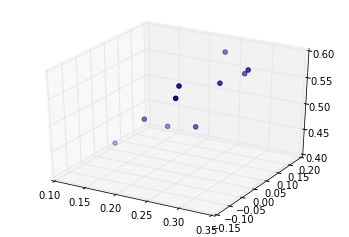

In [6]:
%pylab inline

ax = axes(projection='3d')
x, y, z = array(reached_point).T
ax.scatter3D(x, y, z)

## Setup and run an Explauto experiment with Poppy

Now we want to run the real experiment and really start learning the robot IK.

### Setup the models

In this notebook, we will use a very simple setup: **random goal babling** as the interest model and **nearest neighbor** for the sensori-motor model. Of course, the idea is to show you how to setup a simple experiment with Poppy so you can freely design your own experiment with more complex and more interesting models.

In [7]:
from explauto import InterestModel, SensorimotorModel

sm_model = SensorimotorModel.from_configuration(env.conf, 
                                                'nearest_neighbor', 
                                                'default')

im_model = InterestModel.from_configuration(env.conf, 
                                            env.conf.s_dims,
                                            'random')

### Setup the experiment

The experiment with a Poppy (real or simulated) can be defined exactly as any other experiment in Explauto:

In [8]:
from explauto import Agent, Experiment

agent = Agent(env.conf, sm_model, im_model)
xp = Experiment(env, agent)

### Define the testcases

We will define a simple (and probably not so interesting for our task?) testcases. We will define a "dense" 3D grid of 3x3x3 points.

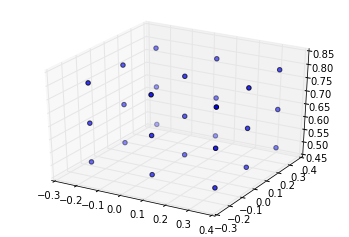

In [9]:
n = 3j
X, Y, Z = numpy.mgrid[s_mins[0] + 0.1: s_maxs[0]:n - 0.1, 
                      s_mins[1] + 0.1: s_maxs[1]:n - 0.1, 
                      s_mins[2] + 0.1: s_maxs[2]:n - 0.1]

dense_testcase = numpy.column_stack((X.flat, Y.flat, Z.flat))

ax = axes(projection='3d')
ax.scatter3D(X, Y, Z)

For time saving purposes, we will run a rather short experiment (100 runs) and the results should thus be interpreted in that regard. Once again, feel free to play with the parameters of the experiment to make a more interesting one!

In [10]:
xp.evaluate_at([1, 10, 25, 50, 100], dense_testcase)

## Run!

Now that we have everything setup and ready, we can finally run the experiment.

**Note that it will take about 5-10 minutes depending on how fast the simulation can run on your computer! So maybe you should first try with a shorter experiment.**

In [11]:
xp.run()

## Plotting results and interpretation

You can of course use the classical plot functionalities of Explauto:

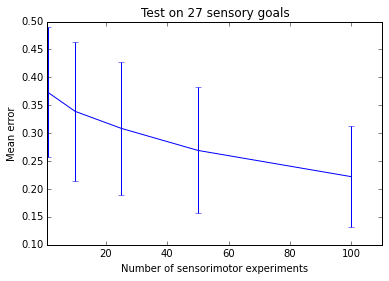

In [12]:
ax = axes()
xp.log.plot_learning_curve(ax)

You can also plot the "chosen" vs "reached" point (here projected on the x, y plan).

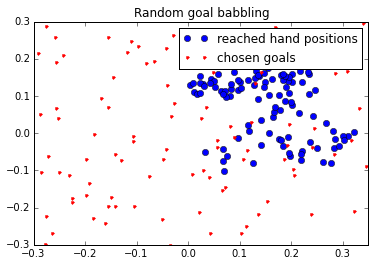

In [13]:
ax = axes()
title(('Random goal babbling'))

xp.log.scatter_plot(ax, (('sensori', [0, 1]),))
xp.log.scatter_plot(ax, (('choice', [0, 1]),), marker='.', color='red')


legend(['reached hand positions', 'chosen goals'])

### Save the trained models so they can be reused later on

You can save explauto models (both interest or sensorimotor) and reload them later. This is particularly useful when:

* you run a very long experiment and want to regularly save the results so you can restore it
* want to transfer trained models to another environment (of course they need to be close enough so the models correspond)

Here, we will show you how to save the models of the experiment you just ran in simulation so they can be re-used on the real robot. To do that, we will use the [pickle](https://docs.python.org/2/library/pickle.html) python module.

In [14]:
import pickle

with open('simu-training.im', 'w') as f: 
    pickle.dump(im_model, f)
    
with open('simu-training.sm', 'w') as f:
    pickle.dump(sm_model, f)

The code above will save the trained models to your hard drive. You can store this file anywhere you want. But you will have to upload them to the real robot so they can be reused on this platform.

# 2. Reuse the learnt IK on the real robot

**Even if this section is written in the same notebook for consistency, this part is intended to be run on a real robot. Thus, you should start again this notebook from this point on the Jupyter server hosted on the robot. As pointed above, you should also upload your saved models on the robot, so they can be reused in the rest of this tutorial.**

A key feature of the PoppyEnvironment in Explauto (and of the Poppy ecosystem in general) is that it let you seamlessly switch from a simulated robot to a real one. This will let us reuse the IK we just learnt in simulation to test it on a real robot.

To do that, we will use the possibility to save and load models in Explauto. The idea is to train the models in simulation (what you did above) and create a new environment (based on the real robot) that will use the pretrained models.

*Note: you will need to upload the saved models to the robot hard drive (using the upload features of the Notebook for instance, see the [dedicated section](http://docs.poppy-project.org/en/from-simulation-to-real-robot/using-jupyter.html) of the documentation for more details).*

## Load the previously saved models

To load the sensorimotor model we will simply use the pickle module once again:

In [ ]:
import pickle

from explauto import SensorimotorModel

with open('simu-training.sm') as f:
    sm_model = pickle.load(f)

*We assumed here that you upload the trained models in the same folder than the notebook. Of course, you can freely modify the path and filename to match the correct path.*

Here we only need the sensorimotor model as we will not continue exploring but only exploit previous data. Though, the interest model could be loaded in exactly the same way. 

You can check that what you obtain are really the trained model. And that you can use it to perform inverse prediction. The inverse prediction here, $f: s \rightarrow m$, corresponds here to computing the joints position to need a cartesian position: i.e. the inverse kinematics.

For instance:

In [ ]:
sm_model.inverse_prediction([0.0, 0.0, 0.6])

Will give you the joint angles to send to the motor of the left arm to reach the (0, 0, 0.6) 3D position.

## Create a PoppyEnvironment based on the real robot

We will then create a new PoppyEnvironment, this time using a real robot. Of course to do that, you need to be connected on the real PoppyHumanoid. Otherwise, you will just get an error saying that pypot did not manage to "ping" the motors.

In [ ]:
from poppy.creatures import PoppyHumanoid

real_poppy = PoppyHumanoid()

You should then put the robot in a stable position, and make sure the motor of its left arm are stiff. **This will actually make the robot move to its standing position!**

In [ ]:
real_poppy.stand_position.start()

for m in real_poppy.motors:
    m.compliant = False

Then, the environment can be created exactly like the one using V-REP. Note that we will not use tracker in this case and thus we will not be able to update the models as the sensori part will not give any information. We will directly use the bounds stored in the models to make sure we are coherent.

In [ ]:
from explauto.environment.poppy import PoppyEnvironment

real_env = PoppyEnvironment(real_poppy, 
                            real_poppy.l_arm, 2.0,
                            None, None,
                            sm_model.conf.m_mins, sm_model.conf.m_maxs, sm_model.conf.s_mins, sm_model.conf.s_maxs)

## Reuse of the trained models

As shown above, we can use our sensorimotor model to compute the inverse kinematics and send the results as a motor command to our environment (it will make the robot move):

In [ ]:
m_ag = sm_model.inverse_prediction([0.1, -0.3, 0.6])

m_env = real_env.compute_motor_command(m_ag)
real_env.compute_sensori_effect(m_env)

This can be easily wrapped in a function:

In [ ]:
def goto(pos, duration=2.0):
    m_ag = sm_model.inverse_prediction(pos)
    m_env = real_env.compute_motor_command(m_ag)
    
    real_env.move_duration = duration
    real_env.compute_sensori_effect(m_env)

*Note that we directly change the move duration defined in the environment to get a finer control over the speed of the movement.*

You can then use this function to evaluate how accurate is the trained IK. It can also be used to follow a trajectory for instance a circle:

In [ ]:
import numpy

r = .1
x0, y0, z0 = (0.1, -0.3, 0.6)

goto((x0, y0, z0), 1.)

for alpha in numpy.arange(0, 2 * numpy.pi, .5):
    x = r * numpy.cos(alpha) + x0
    z = r * numpy.sin(alpha) + z0
    
    goto((x, y0, z), .5)